Using v2 dataset. 80/20 split, no separate test. Time-based split.
This notebook is mostly based on `model-fastai-time.ipynb`.

Adding data augmentation here. I'd like to get higher precision.

Conclusion: this is probably too extreme augmentations. Performance suffers. Try again.

In [39]:
from random import random
from pathlib import Path

# import * appears to be the fast.ai way of doing things,
# even though every instinct in me says "don't do this" :)
from fastai.vision import *  
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [48]:
MODEL_NAME = "model-fastai-time-with-tfms"

In [40]:
path = Path("~/data/split-v2-time").expanduser()

In [41]:
tfms = get_transforms(max_rotate=5)

In [21]:
list((path / "train/BirdHome").glob("*.jpeg"))[:10]

[PosixPath('/home/jvlier/data/split-v2-time/train/BirdHome/20200510T012101.jpeg'),
 PosixPath('/home/jvlier/data/split-v2-time/train/BirdHome/20200510T213501.jpeg'),
 PosixPath('/home/jvlier/data/split-v2-time/train/BirdHome/20200504T093001.jpeg'),
 PosixPath('/home/jvlier/data/split-v2-time/train/BirdHome/20200505T053301.jpeg'),
 PosixPath('/home/jvlier/data/split-v2-time/train/BirdHome/20200503T204601.jpeg'),
 PosixPath('/home/jvlier/data/split-v2-time/train/BirdHome/20200504T200201.jpeg'),
 PosixPath('/home/jvlier/data/split-v2-time/train/BirdHome/20200507T055301.jpeg'),
 PosixPath('/home/jvlier/data/split-v2-time/train/BirdHome/20200505T203201.jpeg'),
 PosixPath('/home/jvlier/data/split-v2-time/train/BirdHome/20200504T181501.jpeg'),
 PosixPath('/home/jvlier/data/split-v2-time/train/BirdHome/20200507T054701.jpeg')]

In [44]:
def get_ex(): return open_image(random.choice(list((path / "train/BirdHome").glob("*.jpeg"))))

def plots_f(rows, cols, width, height, **kwargs):
    ex = get_ex()
    [ex.apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


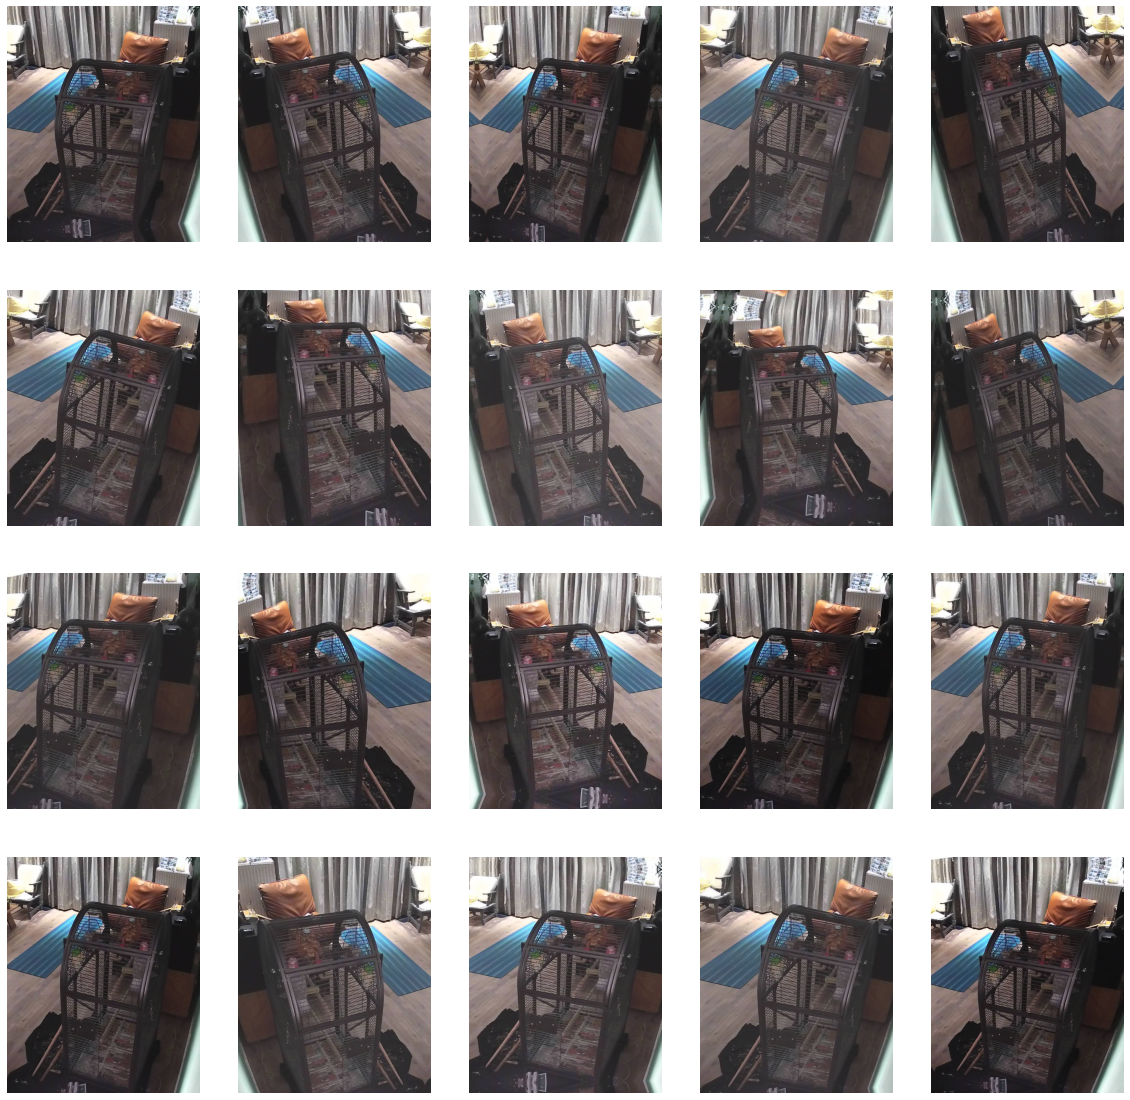

In [38]:
plots_f(4, 5, 20, 20)

In [43]:
data = ImageDataBunch.from_folder(path, bs=32, ds_tfms=tfms)

It seems to be already normalized (check with `data.one_batch(DatasetType.Train)`)

This loads a model with pretrained weights (imagenet?), custom head, everything is frozen apart from the head.

In [45]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps=.6)

Dropout control with `ps`, default is .5.
I think it is like keras: the probability to zero out inputs.

In [46]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


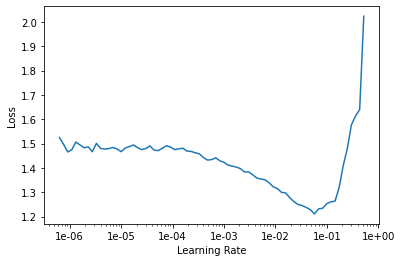

In [47]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(2, 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.517043,0.427022,0.791163,11:07
1,0.230738,0.270551,0.886512,12:51


In [50]:
learn.save(f"{MODEL_NAME}-02epoch")

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


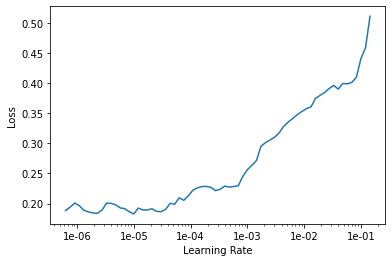

In [51]:
learn.unfreeze()
learn.data.batch_size = 28
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(2, max_lr=[1e-6, 2e-6, 1e-5])

epoch,train_loss,valid_loss,accuracy,time
0,0.200674,0.234924,0.898605,14:53
1,0.219081,0.273864,0.882791,14:54


In [ ]:
learn.save("model-fastai-2-time-2epochs-plus2unfrozen")

### Evaluate

In [ ]:
pred_train = learn.get_preds(ds_type=DatasetType.Train)

In [ ]:
accuracy(*pred_train)

In [52]:
pred_cv = learn.get_preds(ds_type=DatasetType.Valid)

In [53]:
accuracy(*pred_cv)

tensor(0.8865)

In [55]:
pred_cv_tta = Learner.TTA(learn)

In [57]:
accuracy(*pred_cv_tta)

tensor(0.9088)

In [ ]:
np.unique(pred_train[1], return_counts=True)

In [ ]:
def sklearn_metrics(preds_output):
    preds, labels = preds_output
    pred_classes = (preds > .5).numpy().astype(int)[:, 1]
    
    acc = accuracy_score(labels, pred_classes)
    prec = precision_score(labels, pred_classes)
    recall = recall_score(labels, pred_classes)
    f1 = 2 * prec * recall / (prec + recall)

    print(f"Accuracy:  {acc:.3f}")  # Sanity check
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1:        {f1:.3f}")

In [ ]:
sklearn_metrics(pred_train)

In [ ]:
sklearn_metrics(pred_cv)

Low-ish precision means that we are getting false positives while predicting BirdRoaming. About 1 in 10.
So sometimes we think the bird is roaming, while it's actually still there. Would be nice to get this a bit higher.